In [179]:
import numpy as np
from scipy.spatial.distance import euclidean, minkowski
import scipy
import torch

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train import SiameseLSTMNet
from src.siamese_net_sound_similarity.soft_dtw import SoftDTW


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

%matplotlib inline

In [180]:
DISTANCE='euclidean'
STEP_PATTERN = 'typeIc'
CLOSED_END_STEP_PATTERN = "typeIc"
# DISTANCE=lambda x, y : minkowski(x,y, 1)

## Load data

In [181]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.02
}

In [182]:
preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [183]:
n_mini_batch_size = 1
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

Text(0.5,1,'negative DTW = 0.0790')

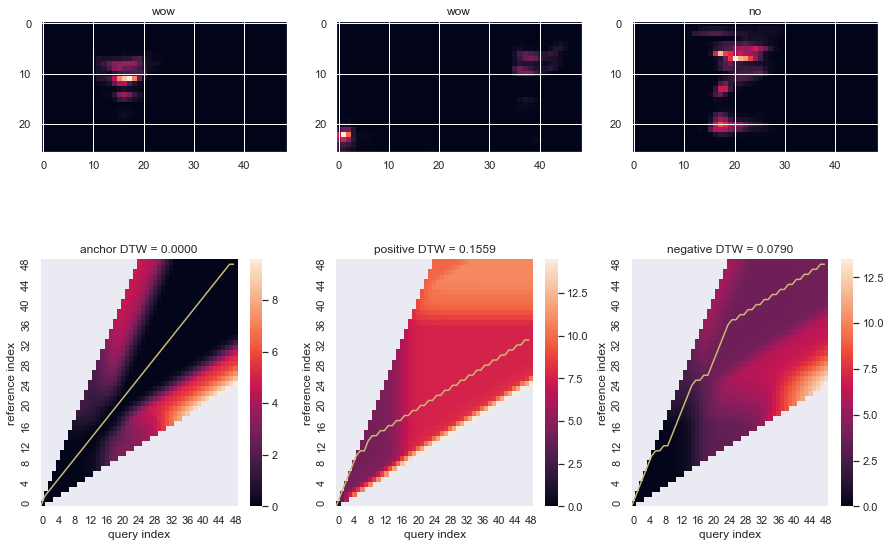

In [184]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(data['x'][i].T)
# fig.colorbar(im)
label = index_to_word[data['y'][0]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[data['y'][0]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][0]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = data['x'][i]

# self dtw (extpected to be 0)

y = data['x'][i]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


# negative dtw

y = non_duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

# Gather Data for analysis

In [186]:
n_mini_batch_size = 2000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


## DTW distribution on raw data

In [187]:

# initialize dist_lists

duplicates_dtw = []
non_duplicates_dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    
    y_duplicate = duplicates['x'][i].squeeze()
    duplicates_dtw.append(dtwalign.dtw(x, y_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).normalized_distance)

    y_non_duplicate = non_duplicates['x'][i].squeeze()
    non_duplicates_dtw.append(dtwalign.dtw(x, y_non_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).normalized_distance)    

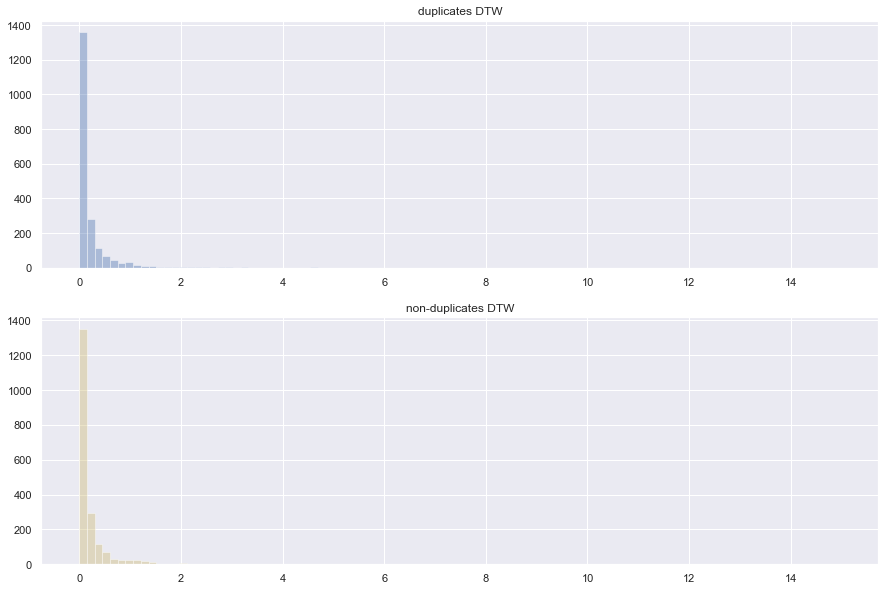

In [188]:
bins = np.linspace(0, min(max(np.max(duplicates_dtw), np.max(non_duplicates_dtw)), 100.), 100)
fig, axes = plt.subplots(2, 1, figsize=(15,10))

duplicates_dtw_filtered = np.array(duplicates_dtw)[np.where(np.array(duplicates_dtw) < 100.)]
non_duplicates_dtw_filtered = np.array(non_duplicates_dtw)[np.where(np.array(non_duplicates_dtw) < 100.)]


sns.distplot(duplicates_dtw,  bins=bins, ax=axes[0], kde=False)
axes[0].title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw, bins=bins,  color='y', ax=axes[1], kde=False)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

### KL Divergence between two DTW distributions:

In [189]:
hist_dup, _ = np.histogram(duplicates_dtw)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


DKL is: 0.0325


### As it can be seen, DTW calculated on MFCCs signals failed to capture different and similar samples showing no significant difference between duplicates and non-duplicates pairs. Kullback-Leibler divergence just proves this fact that P (distribution of distances between duplicate samples) and Q (non-duplicate ones) have no significant difference.

# Improving DTW using latent variables from LSTM classifier as a signal

In [193]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_09_26_2019_02_48_PM/net_0.515625.net'

nn = torch.load(nn_fname)

############################################################################
# PREFIX LENGTH : 50
############################################################################


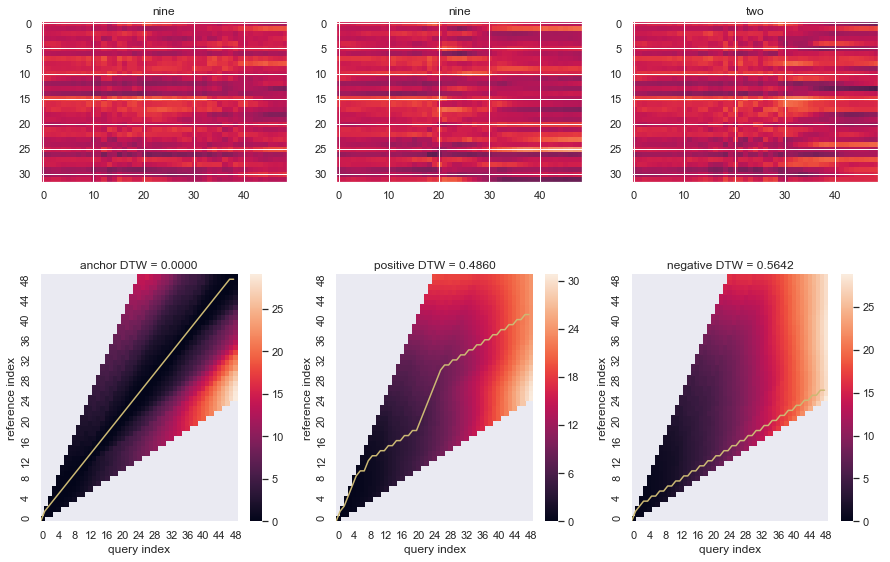

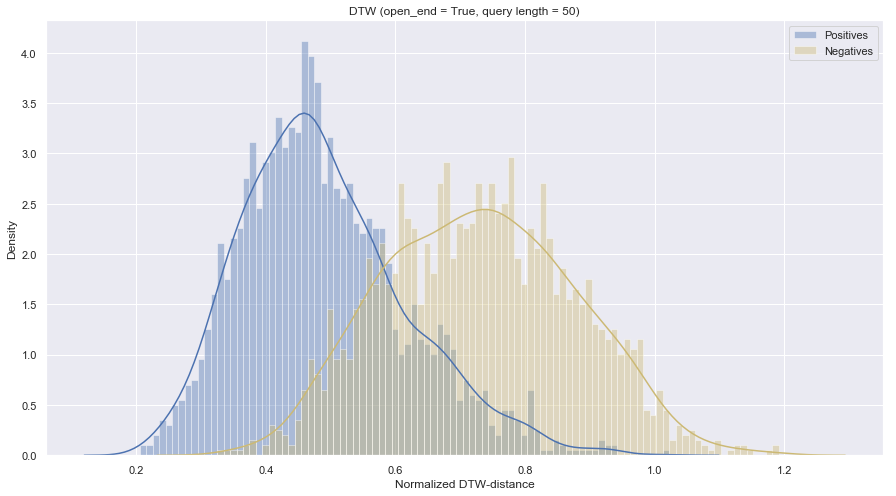

DKL is: 1.8612


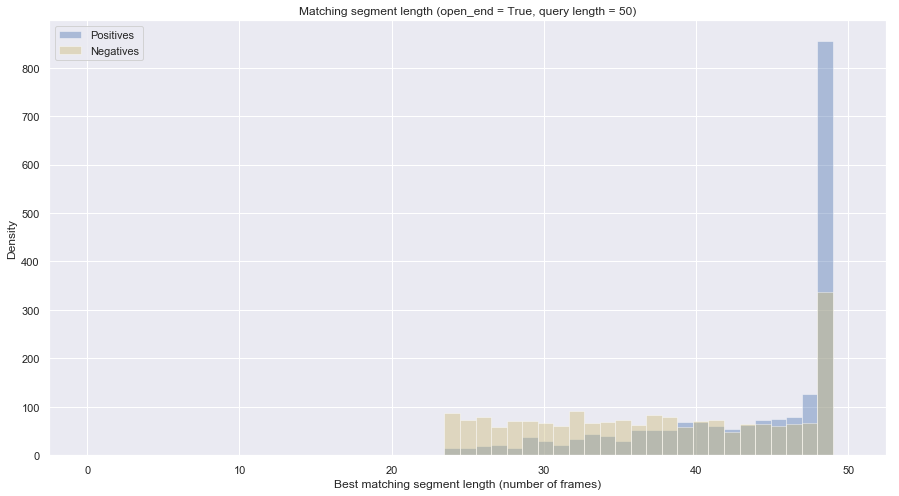

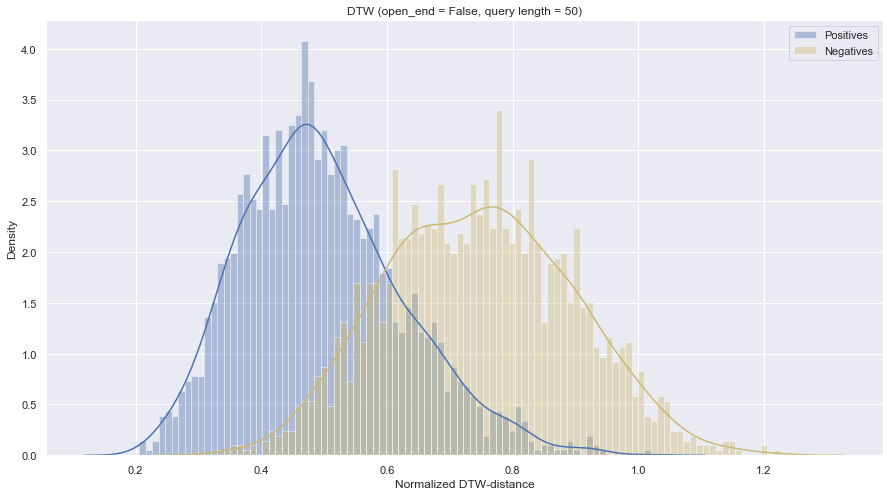

DKL is: 1.8855
############################################################################
# PREFIX LENGTH : 40
############################################################################


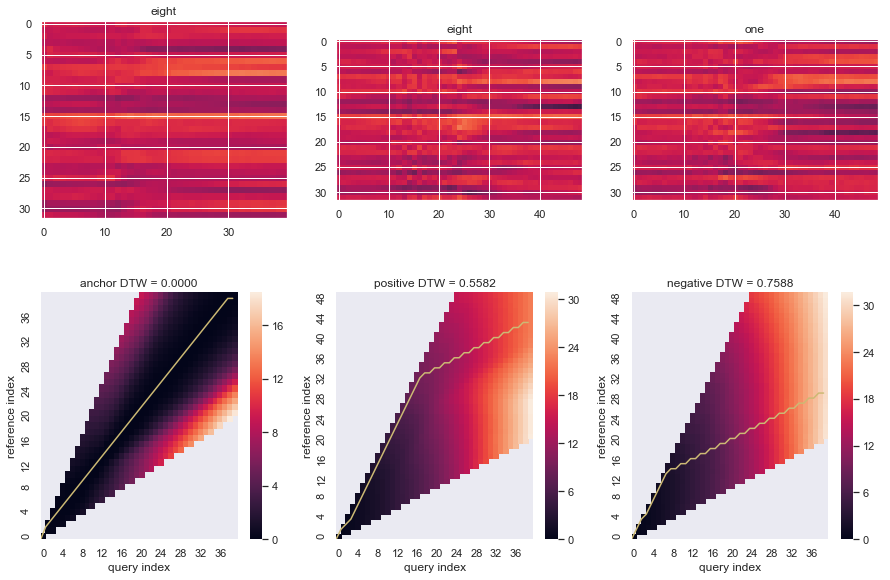

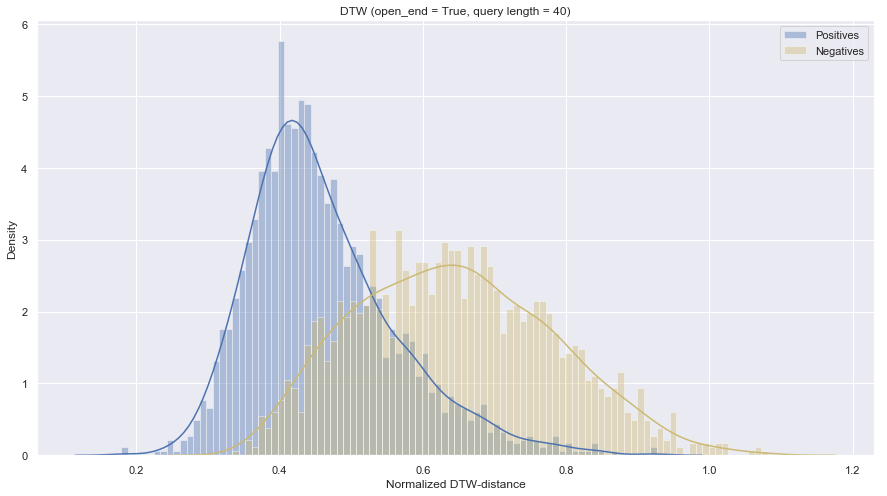

DKL is: 1.4832


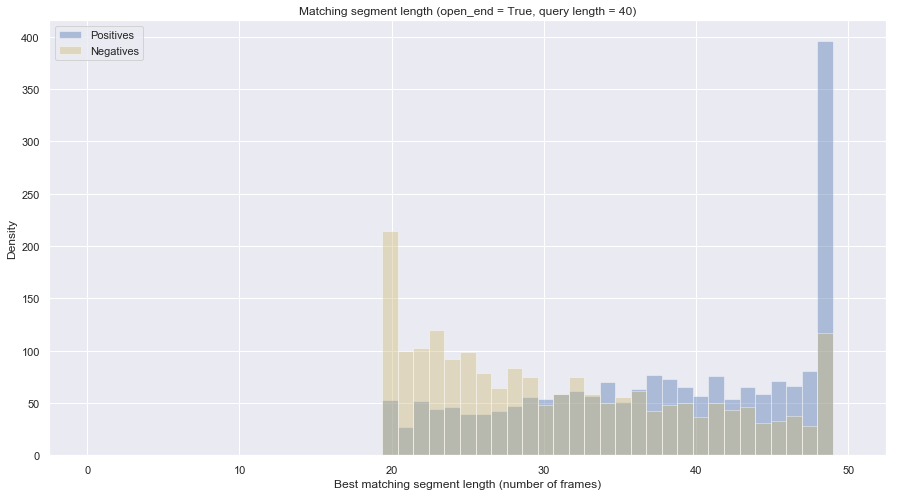

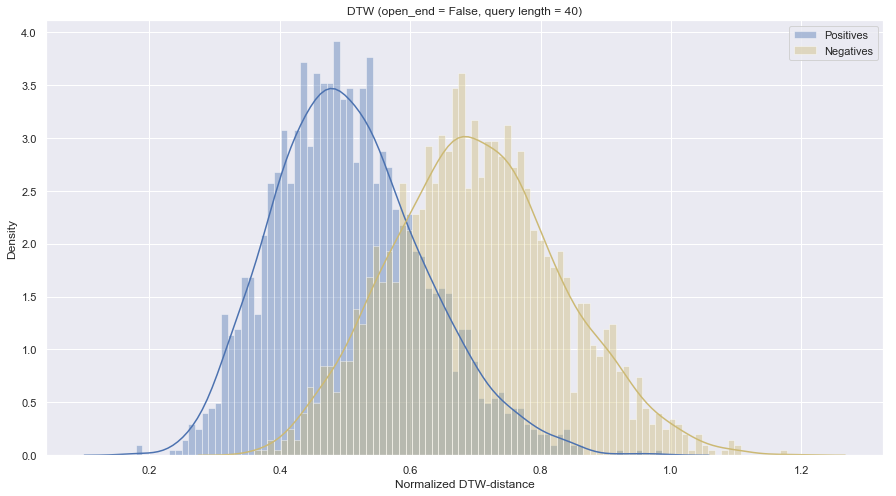

DKL is: 1.5984
############################################################################
# PREFIX LENGTH : 30
############################################################################


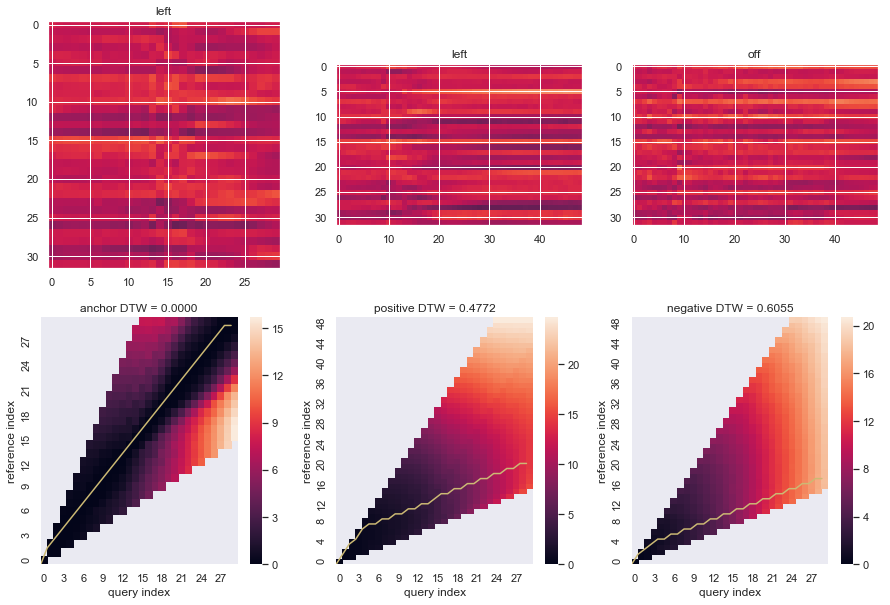

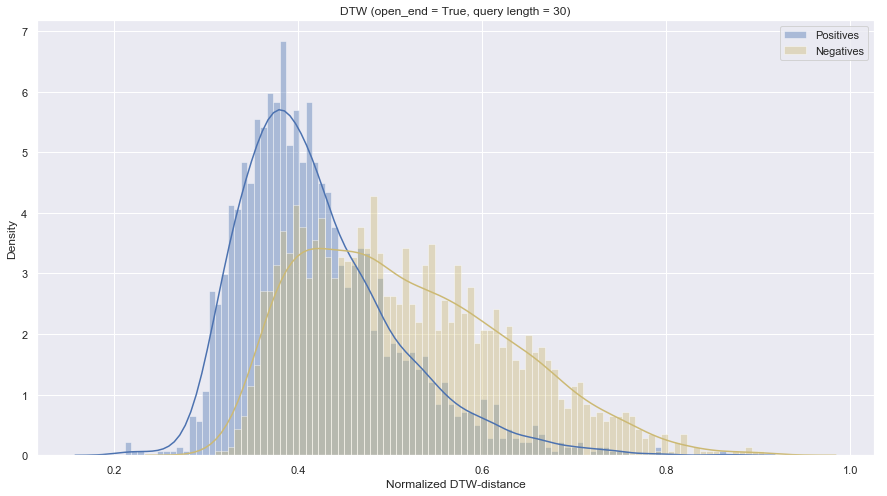

DKL is: 0.7720


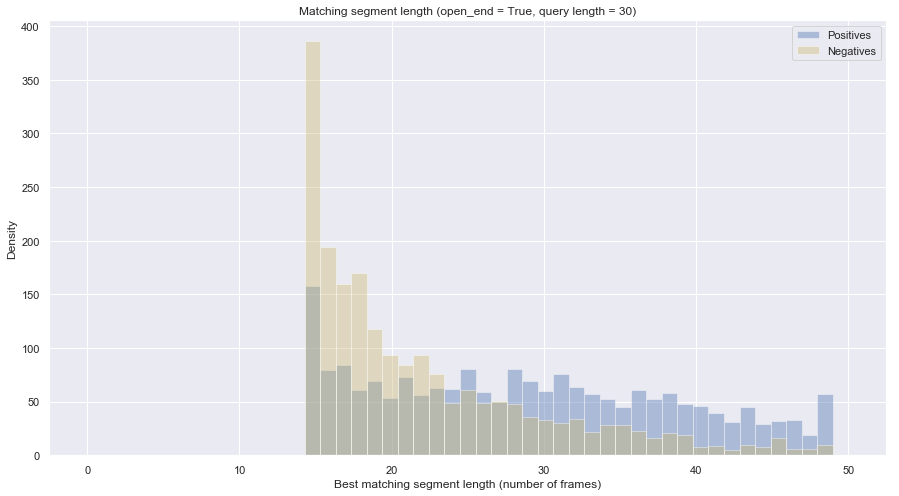

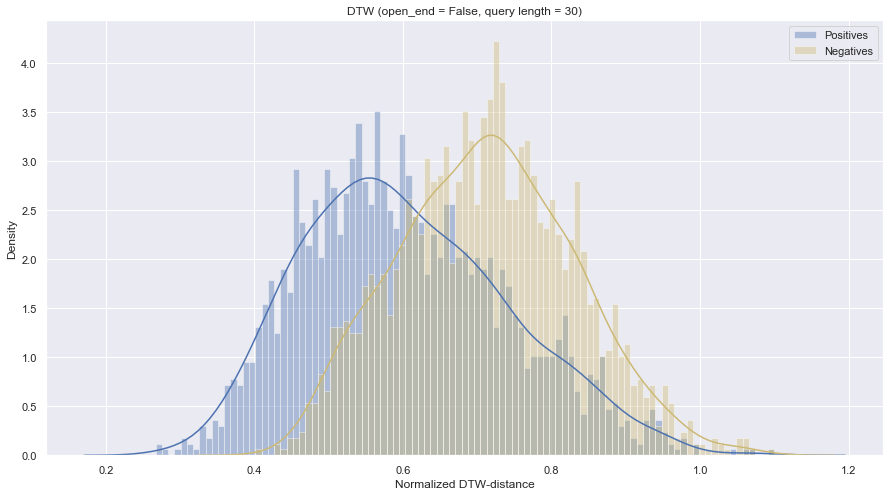

DKL is: 0.8334
############################################################################
# PREFIX LENGTH : 20
############################################################################


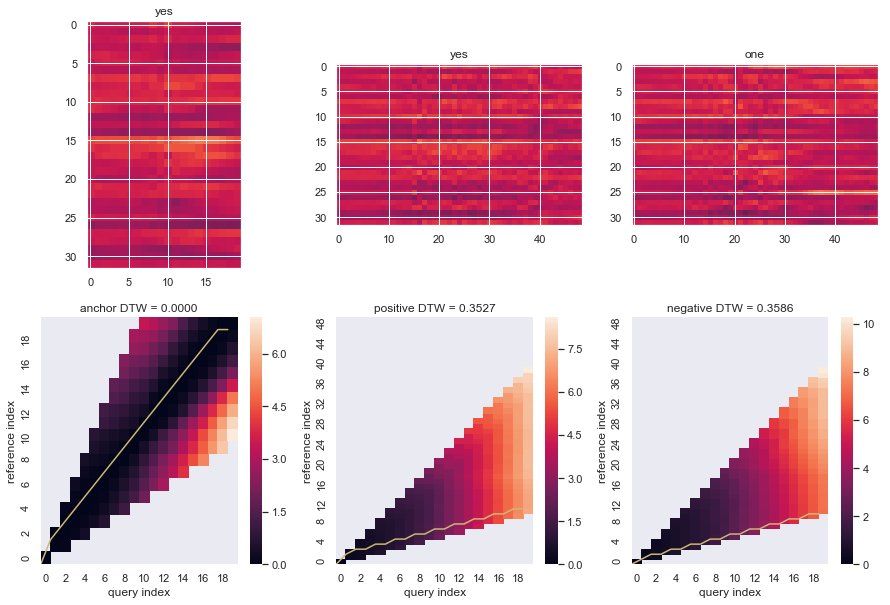

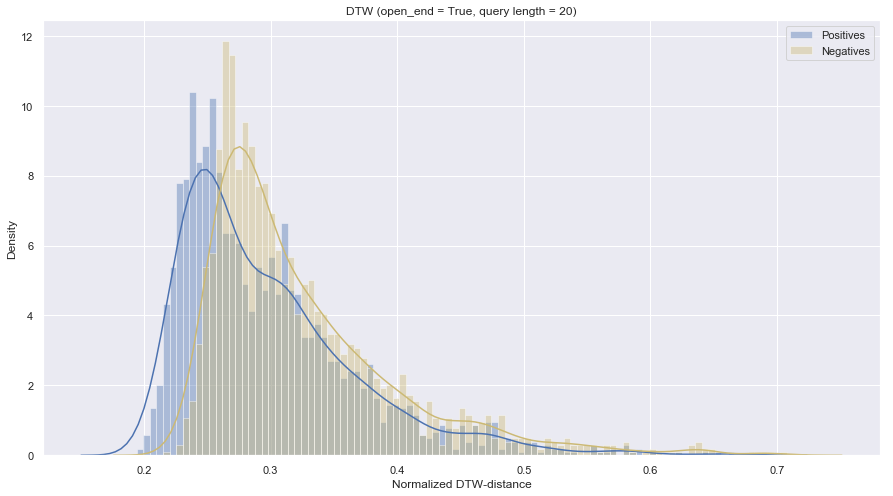

DKL is: 0.6910


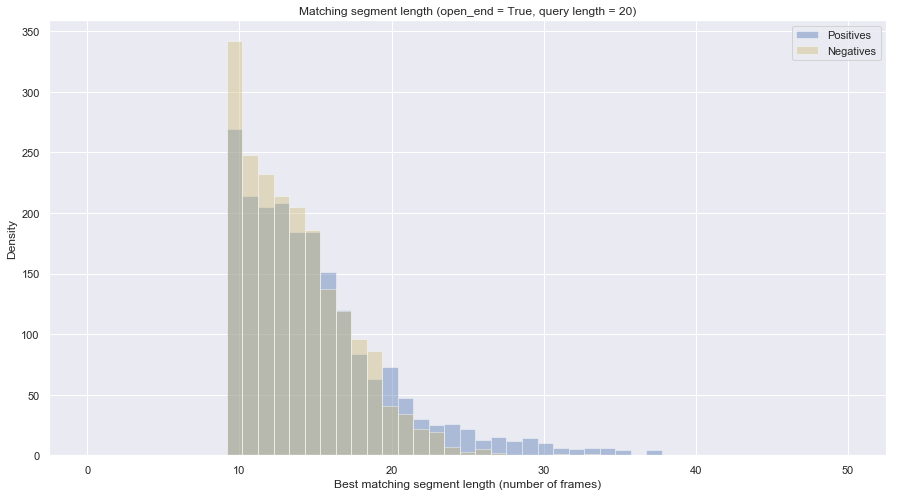

ValueError: no alignment path found

In [194]:
PREFIX_LENS = [50, 40, 30, 20]

for PREFIX_LEN in PREFIX_LENS:
    print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
    nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()


    z, *_ = nn.single_forward(nn_input)
    z = z.detach().cpu().numpy()

    duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
    duplicates_z = duplicates_z.detach().cpu().numpy()

    non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
    non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

    #########################################################################
    # Show example
    #########################################################################

    i = np.random.randint(data['y'].shape[0])
    sample_idx = i

    fig, axes = plt.subplots(2, 3, figsize=(15,10))

    # plt.figure()
    im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
#     axes[0][0].colorbar()
    label = index_to_word[data['y'][i]]
    axes[0][0].title.set_text(f'{label}')

    axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
    # plt.colorbar()
    label = index_to_word[data['y'][i]]
    axes[0][1].title.set_text(f'{label}')


    axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
    # plt.colorbar()
    label = index_to_word[non_duplicates['y'][i]]
    axes[0][2].title.set_text(f'{label}')

    # DTW

    x = z[sample_idx]

    # self dtw (extpected to be 0)

    y = z[sample_idx]
    res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    res.plot_path(ax=axes[1][0])
    axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


    # positive dtw

    y = duplicates_z[sample_idx]
    res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    res.plot_path(ax=axes[1][1])
    axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


    # negative dtw

    y = non_duplicates_z[sample_idx]
    res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
    res.plot_path(ax=axes[1][2])
    axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

    plt.show()

    ###########################################################################
    # DTW
    ###########################################################################

    ##########################################################################
    #OPEN END = TRUE
    ##########################################################################

    # initialize dist_lists

    duplicates_dtw_z = []
    non_duplicates_dtw_z = []

    duplicates_bmis = []
    non_duplicates_bmis = []

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()

        y_duplicate = duplicates_z[i].squeeze()
        d = dtwalign.dtw(x, y_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
        duplicates_dtw_z.append(d.normalized_distance)
        duplicates_bmis.append(d.path[-1, -1])

        y_non_duplicate = non_duplicates_z[i].squeeze()
        d = dtwalign.dtw(x, y_non_duplicate, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
        non_duplicates_dtw_z.append(d.normalized_distance)
        non_duplicates_bmis.append(d.path[-1, -1])

    # Show DTW

    bins = np.linspace(min(np.min(duplicates_dtw_z), np.min(non_duplicates_dtw_z)),
                       max(np.max(duplicates_dtw_z), np.max(non_duplicates_dtw_z)),
                       100)
    fig, axes = plt.subplots(1, 1, figsize=(15,8))

    duplicates_bmis = np.array(duplicates_bmis)
    non_duplicates_bmis = np.array(non_duplicates_bmis)


    sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
    axes.title.set_text(f'DTW (open_end = True, query length = {PREFIX_LEN})')
    plt.xlabel('Normalized DTW-distance')
    plt.ylabel('Density')


    sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
    axes.legend()
    # axes[1].title.set_text('non-duplicates DTW')
    plt.show()

    hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
    hist_dup = hist_dup / np.sum(hist_dup)

    hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
    hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

    dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
    print(f"DKL is: {dkl:.4f}")

    # plot matching segment length

    bins = np.linspace(0, 50., 50)
    fig, axes = plt.subplots(1, 1, figsize=(15,8))

    sns.distplot(duplicates_bmis, ax=axes,  label="Positives", kde=False, bins=bins)
    axes.title.set_text(f'Matching segment length (open_end = True, query length = {PREFIX_LEN})')

    sns.distplot(non_duplicates_bmis,   color='y', ax=axes, label='Negatives', kde=False, bins=bins)
    axes.legend()
    plt.xlabel('Best matching segment length (number of frames)')
    plt.ylabel('Density')
    plt.show()

    ##########################################################################
    # OPEN END = False
    ##########################################################################

    # initialize dist_lists

    duplicates_dtw_z = []
    non_duplicates_dtw_z = []

    duplicates_bmis = []
    non_duplicates_bmis = []

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()

        y_duplicate = duplicates_z[i].squeeze()
        d = dtwalign.dtw(x, y_duplicate, dist=DISTANCE, step_pattern=CLOSED_END_STEP_PATTERN, open_end=False)
        duplicates_dtw_z.append(d.normalized_distance)
        duplicates_bmis.append(d.path[-1, -1])

        y_non_duplicate = non_duplicates_z[i].squeeze()
        d = dtwalign.dtw(x, y_non_duplicate, dist=DISTANCE, step_pattern=CLOSED_END_STEP_PATTERN, open_end=False)
        non_duplicates_dtw_z.append(d.normalized_distance)
        non_duplicates_bmis.append(d.path[-1, -1])


    bins = np.linspace(min(np.min(duplicates_dtw_z), np.min(non_duplicates_dtw_z)),
                       max(np.max(duplicates_dtw_z), np.max(non_duplicates_dtw_z)),
                       100)
    fig, axes = plt.subplots(1, 1, figsize=(15,8))

    sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
    axes.title.set_text(f'DTW (open_end = False, query length = {PREFIX_LEN})')
 
    sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
    axes.legend()
    plt.xlabel('Normalized DTW-distance')
    plt.ylabel('Density')
    # axes[1].title.set_text('non-duplicates DTW')
    plt.show()

    hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
    hist_dup = hist_dup / np.sum(hist_dup)

    hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
    hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

    dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
    print(f"DKL is: {dkl:.4f}")




############################################################################
# SOFT DTW
############################################################################
############################################################################
# PREFIX LENGTH : 50
############################################################################


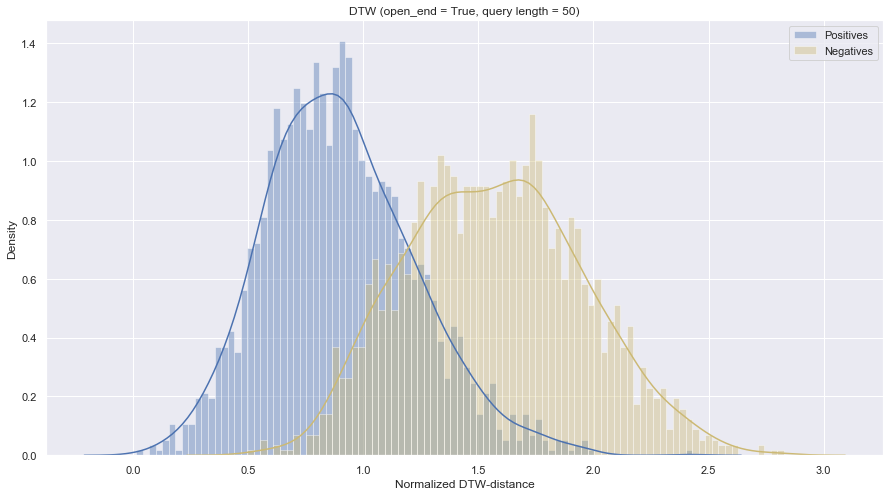

DKL is: 2.3492


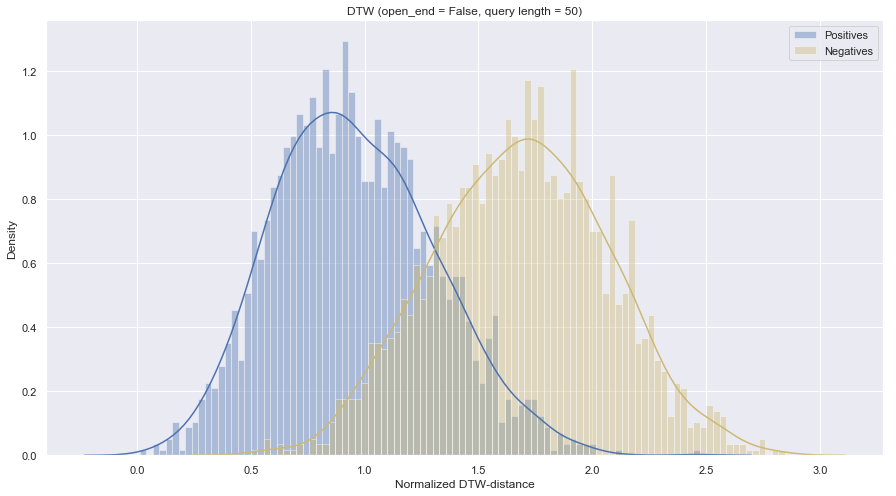

DKL is: 2.3141
############################################################################
# PREFIX LENGTH : 40
############################################################################


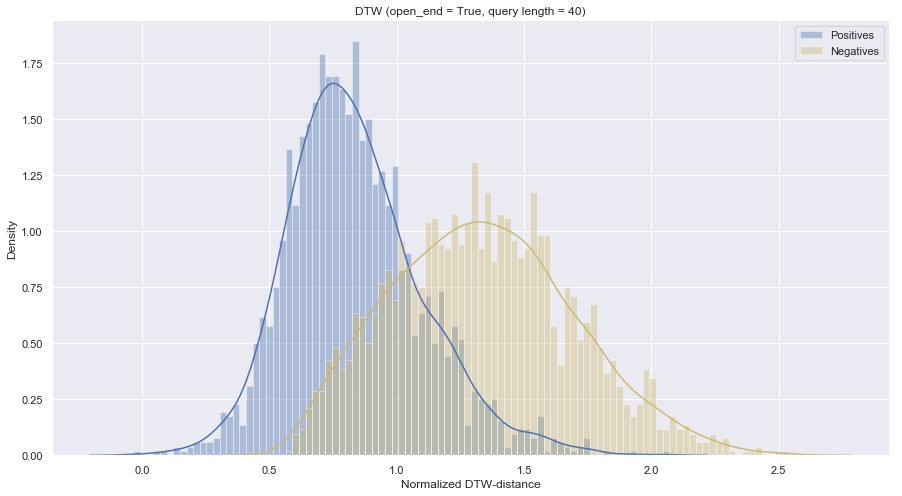

DKL is: 1.6798


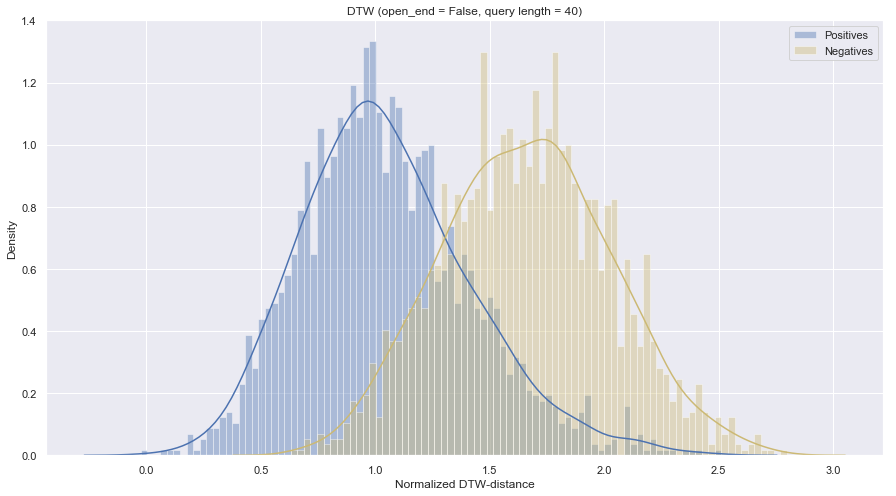

DKL is: 1.8748
############################################################################
# PREFIX LENGTH : 30
############################################################################


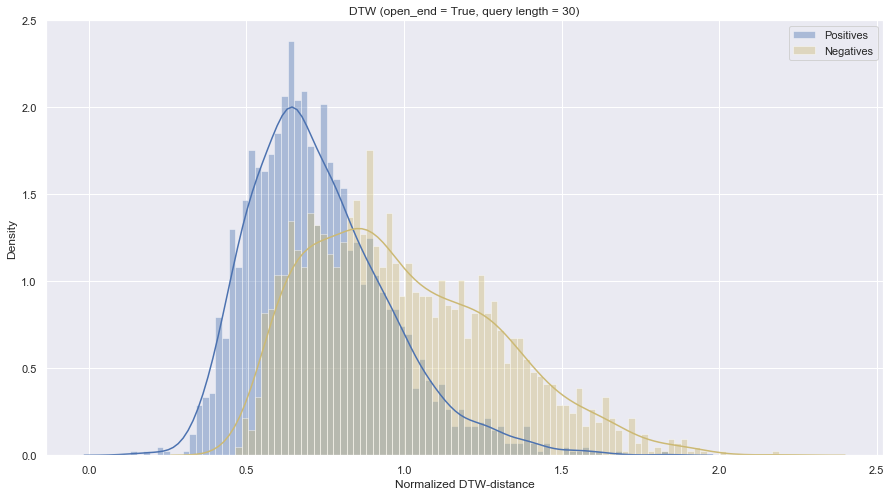

DKL is: 0.9467


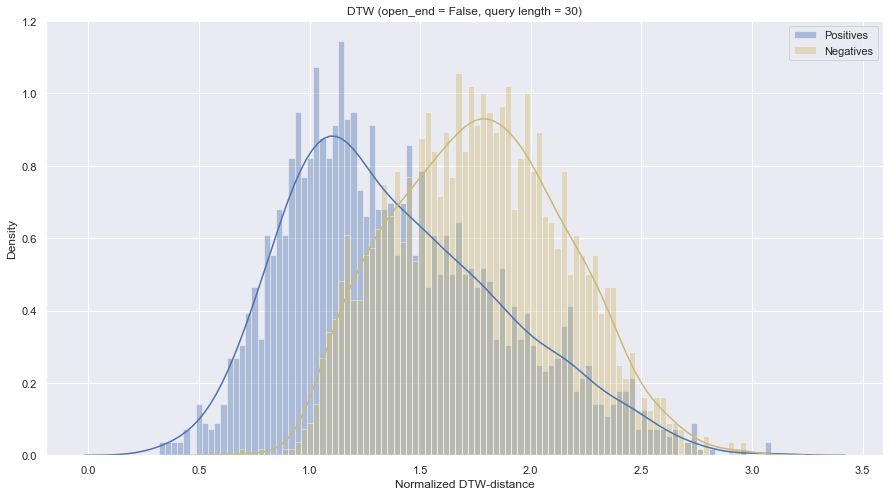

DKL is: 1.1481
############################################################################
# PREFIX LENGTH : 20
############################################################################


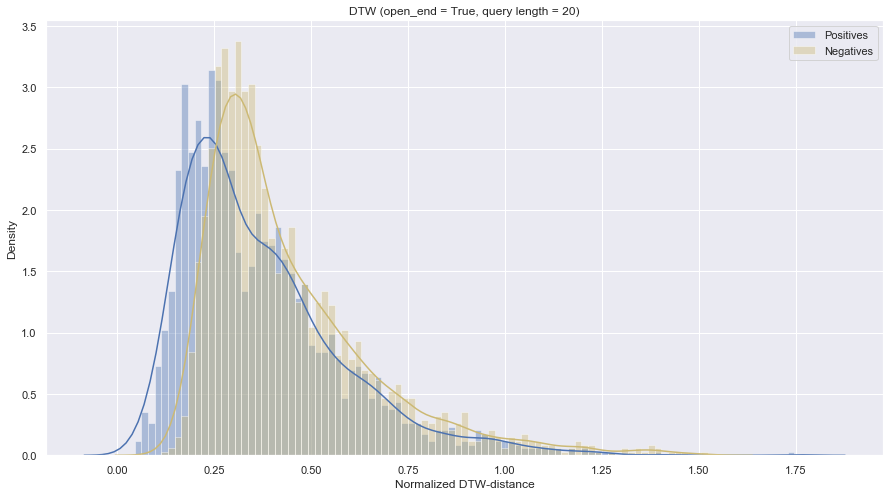

DKL is: 0.4698


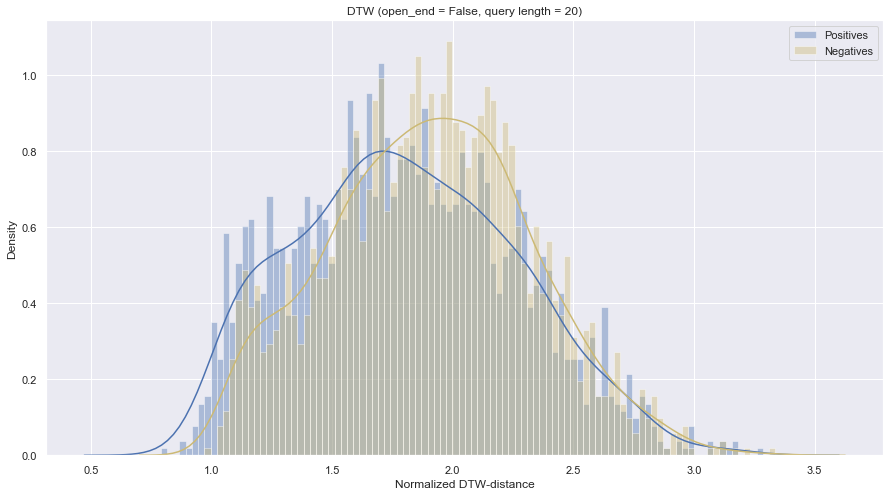

DKL is: 0.1708


In [195]:
print(f"############################################################################\n\
# SOFT DTW\n\
############################################################################")

PREFIX_LENS = [50, 40, 30, 20]

for PREFIX_LEN in PREFIX_LENS:
    print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
    nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()


    z, *_ = nn.single_forward(nn_input)
    z = z
    z_detach = z.detach().cpu().numpy()

    duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
    duplicates_z = duplicates_z

    non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
    non_duplicates_z = non_duplicates_z

    #########################################################################
    # Show example
    #########################################################################

#     i = np.random.randint(data['y'].shape[0])
#     sample_idx = i

#     fig, axes = plt.subplots(1, 3, figsize=(15,10))

#     # plt.figure()
#     im = axes[0].imshow(z[i].T, vmin=-1, vmax=1)
# #     axes[0][0].colorbar()
#     label = index_to_word[data['y'][i]]
#     axes[0].title.set_text(f'{label}')

#     axes[1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
#     # plt.colorbar()
#     label = index_to_word[data['y'][i]]
#     axes[1].title.set_text(f'{label}')


#     axes[2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
#     # plt.colorbar()
#     label = index_to_word[non_duplicates['y'][i]]
#     axes[2].title.set_text(f'{label}')

#     # DTW

#     x = z[sample_idx]

#     # self dtw (extpected to be 0)

#     y = z[sample_idx]
#     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
#     res.plot_path(ax=axes[1][0])
#     axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


#     # positive dtw

#     y = duplicates_z[sample_idx]
#     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
#     res.plot_path(ax=axes[1][1])
#     axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


#     # negative dtw

#     y = non_duplicates_z[sample_idx]
#     res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
#     res.plot_path(ax=axes[1][2])
#     axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

    plt.show()

    ###########################################################################
    # DTW
    ###########################################################################

    soft_dtw_loss_open_end = SoftDTW(open_end=True, dist='l1')
    soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')

    
    ##########################################################################
    #OPEN END = TRUE
    ##########################################################################

    # initialize dist_lists

    duplicates_dtw_z = []
    non_duplicates_dtw_z = []

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()

        y_duplicate = duplicates_z[i].squeeze()
        d = soft_dtw_loss_open_end(x, y_duplicate)
        duplicates_dtw_z.append(d.detach().cpu().numpy())

        y_non_duplicate = non_duplicates_z[i].squeeze()
        d = soft_dtw_loss_open_end(x, y_non_duplicate)
        non_duplicates_dtw_z.append(d.detach().cpu().numpy())

    # Show DTW

    bins = np.linspace(min(np.min(duplicates_dtw_z), np.min(non_duplicates_dtw_z)),
                       max(np.max(duplicates_dtw_z), np.max(non_duplicates_dtw_z)),
                       100)
    fig, axes = plt.subplots(1, 1, figsize=(15,8))

    sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
    axes.title.set_text(f'DTW (open_end = True, query length = {PREFIX_LEN})')
    plt.xlabel('Normalized DTW-distance')
    plt.ylabel('Density')


    sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
    axes.legend()
    # axes[1].title.set_text('non-duplicates DTW')
    plt.show()

    hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
    hist_dup = hist_dup / np.sum(hist_dup)

    hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
    hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

    dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
    print(f"DKL is: {dkl:.4f}")

#     # plot matching segment length

#     bins = np.linspace(0, 50., 50)
#     fig, axes = plt.subplots(1, 1, figsize=(15,8))

#     sns.distplot(duplicates_bmis, ax=axes,  label="Positives", kde=False, bins=bins)
#     axes.title.set_text(f'Matching segment length (open_end = True, query length = {PREFIX_LEN})')

#     sns.distplot(non_duplicates_bmis,   color='y', ax=axes, label='Negatives', kde=False, bins=bins)
#     axes.legend()
#     plt.xlabel('Best matching segment length (number of frames)')
#     plt.ylabel('Density')
#     plt.show()

    ##########################################################################
    # OPEN END = False
    ##########################################################################

    # initialize dist_lists

    duplicates_dtw_z = []
    non_duplicates_dtw_z = []

    duplicates_bmis = []
    non_duplicates_bmis = []

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()

        y_duplicate = duplicates_z[i].squeeze()
        d = soft_dtw_loss_close_end(x, y_duplicate)
        duplicates_dtw_z.append(d.detach().cpu().numpy())

        y_non_duplicate = non_duplicates_z[i].squeeze()
        d = soft_dtw_loss_close_end(x, y_non_duplicate)
        non_duplicates_dtw_z.append(d.detach().cpu().numpy())


    bins = np.linspace(min(np.min(duplicates_dtw_z), np.min(non_duplicates_dtw_z)),
                       max(np.max(duplicates_dtw_z), np.max(non_duplicates_dtw_z)),
                       100)
    fig, axes = plt.subplots(1, 1, figsize=(15,8))

    sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
    axes.title.set_text(f'DTW (open_end = False, query length = {PREFIX_LEN})')
 
    sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
    axes.legend()
    plt.xlabel('Normalized DTW-distance')
    plt.ylabel('Density')
    # axes[1].title.set_text('non-duplicates DTW')
    plt.show()

    hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
    hist_dup = hist_dup / np.sum(hist_dup)

    hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
    hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

    dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
    print(f"DKL is: {dkl:.4f}")


